Esse notebook é responsável por analisar os dados do arquivo _db/2017/cartola_2017.csv_, fazer as limpezas necessárias nos dados e treinar o modelo para predizer os scores dos jogadores na próxima rodada do Cartola.

# 0. Libraries used and Settings

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import _pickle as pkl
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler

%matplotlib inline

pd.set_option('display.max_columns', 100)

cols_scouts_def = ['CA','CV','DD','DP','FC','GC','GS','RB','SG'] # alphabetical order
cols_scouts_atk = ['A','FD','FF','FS','FT','G','I','PE','PP'] # alphabetical order
cols_scouts = cols_scouts_def + cols_scouts_atk

points = np.array([-2.0, -5.0, 3.0, 7.0, -0.5, -6.0, -2.0, 1.7, 5.0, 5.0, 1.0, 0.7, 0.5, 3.5, 8.0, -0.5, -0.3, -3.5])

# 1. Data Wrangling 

A primeira seção desse notebook será responsável por analisar os dados do cartola e fazer as limpezas necessárias para criar amostras corretas e relevantes para o preditor. Analisando os dados previamente, alguns problemas foram detectados:

- __Jogadores com todos os scouts NANs__.
- __Jogadores com a coluna 'ClubeID' = NAN__.
- __Jogadores com scouts que não equivalem a pontuação__.
- __A coluna 'atletas.clube_id' tem campos repetidos e divergentes__: por exemplo, todos os Atléticos (MG, PR, e GO) são ATL. Além disso, há jogadores com siglas diferentes das equipes que eles jogam (por exemplo, Maicosuel [id: 37851]).
- __A coluna 'athletes.atletas.scout' não é informativa__.
- __Os scouts do jogadores são cumulativos__: ou seja, os scouts dos jogadores vão sendo somados a cada rodada. Entretanto, a pontuação não é. Isso também causa o repetimento de dados.

__Importante__: para manter a consistência dos dados, nenhuma coluna será alterada ou removida, somente adicionada se for o caso. Alguns dados podem ser removidos ou corrigidos quando necessário.

### 1.1 Import

In [2]:
df = pd.read_csv('../../db/cartola_aggregated.csv')
print(df.shape)
df.head(10)

(104543, 33)


,AtletaID,Rodada,ClubeID,Participou,Posicao,Jogos,Pontos,PontosMedia,Preco,PrecoVariacao,FS,PE,A,FT,FD,FF,G,I,PP,RB,FC,GC,CA,CV,SG,DD,DP,GS,ano,Apelido,Status,media,roll.media
0,36443,0,NaN,False,NaN,0.0,0.0,0.00,9.00,0.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2014,NaN,NaN,0.000000,1.00
1,36443,1,285.0,True,gol,1.0,5.0,5.00,10.60,1.60,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,2014,NaN,NaN,2.500000,1.00
2,36443,2,285.0,True,gol,2.0,-3.0,1.00,8.27,-2.33,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2014,NaN,NaN,0.666667,1.00
3,36443,3,285.0,True,gol,3.0,-2.6,-0.20,6.81,-1.46,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2014,NaN,NaN,-0.150000,1.00
4,36443,4,285.0,True,gol,4.0,4.0,0.85,7.96,1.15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,1,2014,NaN,NaN,0.680000,0.68
5,36443,5,285.0,True,gol,5.0,5.0,1.68,8.61,0.65,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,2014,NaN,NaN,1.400000,1.68
6,36443,6,285.0,True,gol,6.0,1.2,1.60,8.02,-0.59,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,2,0,1,2014,NaN,NaN,1.371429,0.92
7,36443,7,285.0,True,gol,7.0,-3.3,0.90,6.75,-1.27,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,3,2014,NaN,NaN,0.787500,0.86
8,36443,8,285.0,True,gol,8.0,3.0,1.16,7.55,0.80,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,2014,NaN,NaN,1.033333,1.98
9,36443,9,285.0,True,gol,9.0,-1.5,0.86,6.71,-0.84,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2014,NaN,NaN,0.780000,0.88


### 1.2 Cleaning

In [3]:
print("Original data shape: ", df.shape)

# remove all rows which all scouts are NANs
df_clean = df.dropna(how='all', subset=cols_scouts)
print('#players with scouts: ', df_clean.shape[0])

# remove rows from round 0 (sanity check only!)
df_clean = df_clean[df_clean['Rodada'] > 0]
print("#rows from 1st round: ", df_clean.shape[0])

# remove all coachs (sanity check only!)
df_clean = df_clean[(df_clean['Posicao'] != "tec") & (~df_clean['Posicao'].isnull())]
print("#rows with valid positions: ", df_clean.shape[0])

# remove all players which have not enrolled some round
df_clean = df_clean[(df_clean['Participou'] == True) | (df_clean['PrecoVariacao'] != 0)]
print("#rows with enrolled players: ", df_clean.shape[0])

# fill NANs with 0
df_clean.fillna(value=0, inplace=True)

print("Data shape after cleaning: ", df_clean.shape)
df_clean.head(10)

Original data shape:  (104543, 33)
#players with scouts:  104543
#rows from 1st round:  101468
#rows with valid positions:  62813
#rows with enrolled players:  26225
Data shape after cleaning:  (26225, 33)


,AtletaID,Rodada,ClubeID,Participou,Posicao,Jogos,Pontos,PontosMedia,Preco,PrecoVariacao,FS,PE,A,FT,FD,FF,G,I,PP,RB,FC,GC,CA,CV,SG,DD,DP,GS,ano,Apelido,Status,media,roll.media
1,36443,1,285.0,True,gol,1.0,5.0,5.00,10.60,1.60,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,2014,0,0,2.500000,1.00
2,36443,2,285.0,True,gol,2.0,-3.0,1.00,8.27,-2.33,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2014,0,0,0.666667,1.00
3,36443,3,285.0,True,gol,3.0,-2.6,-0.20,6.81,-1.46,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2014,0,0,-0.150000,1.00
4,36443,4,285.0,True,gol,4.0,4.0,0.85,7.96,1.15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,1,2014,0,0,0.680000,0.68
5,36443,5,285.0,True,gol,5.0,5.0,1.68,8.61,0.65,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,2014,0,0,1.400000,1.68
6,36443,6,285.0,True,gol,6.0,1.2,1.60,8.02,-0.59,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,2,0,1,2014,0,0,1.371429,0.92
7,36443,7,285.0,True,gol,7.0,-3.3,0.90,6.75,-1.27,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,3,2014,0,0,0.787500,0.86
8,36443,8,285.0,True,gol,8.0,3.0,1.16,7.55,0.80,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,2014,0,0,1.033333,1.98
9,36443,9,285.0,True,gol,9.0,-1.5,0.86,6.71,-0.84,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2014,0,0,0.780000,0.88
10,36443,10,285.0,True,gol,10.0,-4.0,0.37,6.01,-0.70,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2014,0,0,0.345455,-0.92


### 1.3 Update Team for Each Player

In [4]:
df_teams = pd.read_csv('../../db/teamids-consolidated.csv')
df_teams = df_teams.dropna()
print(df_teams.shape)
df_teams.head()

(42, 6)


,nome.cbf,nome.cartola,nome.completo,cod.older,cod.2017,id
0,América - MG,América-MG,America MG,327,327,327
1,America - RN,Atlético-RN,America RN,200,200,200
2,Atlético - GO,Atlético-GO,Atletico GO,201,373,373
3,Atlético - MG,Atlético-MG,Atletico Mineiro,282,282,282
4,Atletico - PR,Atlético-PR,Atletico Paranaense,293,293,293


In [5]:
# do not run this cell twice!
dict_teams_id = dict(zip(df_teams['id'], df_teams['nome.cartola']))
dict_teams_id.update(dict(zip(df_teams['cod.older'], df_teams['nome.cartola'])))

df_clean['ClubeID'] = df_clean['ClubeID'].astype(np.int).map(dict_teams_id)
df_clean = df_clean.dropna()

print(df_clean.shape)
df_clean.head()

(24775, 33)


,AtletaID,Rodada,ClubeID,Participou,Posicao,Jogos,Pontos,PontosMedia,Preco,PrecoVariacao,FS,PE,A,FT,FD,FF,G,I,PP,RB,FC,GC,CA,CV,SG,DD,DP,GS,ano,Apelido,Status,media,roll.media
1,36443,1,Internacional,True,gol,1.0,5.0,5.00,10.60,1.60,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,2014,0,0,2.500000,1.00
2,36443,2,Internacional,True,gol,2.0,-3.0,1.00,8.27,-2.33,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2014,0,0,0.666667,1.00
3,36443,3,Internacional,True,gol,3.0,-2.6,-0.20,6.81,-1.46,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2014,0,0,-0.150000,1.00
4,36443,4,Internacional,True,gol,4.0,4.0,0.85,7.96,1.15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,1,2014,0,0,0.680000,0.68
5,36443,5,Internacional,True,gol,5.0,5.0,1.68,8.61,0.65,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,2014,0,0,1.400000,1.68


### 1.4 Update scouts

Como dito anteriomente, os dados sobre os scouts são cumulativos, ou seja, os scouts de uma rodada são adicionados aos scouts anteriores a cada nova rodada que um jogador participa. Portanto, nessa seção vamos tirar essa acumulação para cada jogador. 

Para isso, dada uma rodada específica, os scouts de um jogador são subtraídos do máximo dos scouts de todas as rodadas anteriores. Repare que assim há chance do scout _Jogo Sem Sofrer Gols (SG)_ ser negativo se o jogador não sofre gols na rodada anterior e sofre na rodada atual. Quando isso acontece, esse scout é atualizado.

In [6]:
def get_scouts_for_round(df, round_):
    suffixes = ('_curr', '_prev')
    cols_current = [col + suffixes[0] for col in cols_scouts]
    cols_prev = [col + suffixes[1] for col in cols_scouts]
    
    df_round = df[df['Rodada'] == round_]
    if round_ == 1: return df_round
    
    df_round_prev = df[df['Rodada'] < round_].groupby('AtletaID', as_index=False)[cols_scouts].max()
    df_players = df_round.merge(df_round_prev, how='left', on=['AtletaID'], suffixes=suffixes)
    
    # if is the first round of a player, the scouts of previous rounds will be NaNs. Thus, set them to zero
    df_players.fillna(value=0, inplace=True)
    
    # compute the scouts 
    df_players[cols_current] = df_players[cols_current].values - df_players[cols_prev].values
    
    # update the columns
    df_players.drop(labels=cols_prev, axis=1, inplace=True)
    df_players = df_players.rename(columns=dict(zip(cols_current, cols_scouts)))
    df_players.SG = df_players.SG.clip_lower(0)
    
    return df_players

In [7]:
# test of get_scouts_for_round method
# df_players = get_scouts_for_round(df_clean[df_clean['ano'] == 2015], 4)
# print(df_players.shape)
# df_players.head()

A célula abaixo cria uma dataframe com os scouts dos jogadores não acumulados.

In [8]:
df_scouts = df_clean[df_clean['ano'] != 2015]
df_scouts_2015 = df_clean[df_clean['ano'] == 2015]

n_rounds = df_scouts_2015['Rodada'].max()
for i in range(1, n_rounds+1):
    df_round = get_scouts_for_round(df_scouts_2015, i)
    print("Shape of round #{0}: {1}".format(i, df_round.shape))
    df_scouts = df_scouts.append(df_round, ignore_index=True)
    
print(df_scouts.shape)
df_scouts.head()

Shape of round #1: (184, 33)
Shape of round #2: (184, 33)
Shape of round #3: (182, 33)
Shape of round #4: (178, 33)
Shape of round #5: (173, 33)
Shape of round #6: (177, 33)
Shape of round #7: (153, 33)
Shape of round #8: (159, 33)
Shape of round #9: (165, 33)
Shape of round #10: (168, 33)
Shape of round #11: (166, 33)
Shape of round #12: (169, 33)
Shape of round #13: (173, 33)
Shape of round #14: (176, 33)
Shape of round #15: (170, 33)
Shape of round #16: (131, 33)
Shape of round #17: (172, 33)
Shape of round #18: (172, 33)
Shape of round #19: (172, 33)
Shape of round #20: (171, 33)
Shape of round #21: (163, 33)
Shape of round #22: (167, 33)
Shape of round #23: (162, 33)
Shape of round #24: (163, 33)
Shape of round #25: (172, 33)
Shape of round #26: (0, 33)
Shape of round #27: (166, 33)
Shape of round #28: (165, 33)
Shape of round #29: (168, 33)
Shape of round #30: (163, 33)
Shape of round #31: (161, 33)
Shape of round #32: (168, 33)
Shape of round #33: (167, 33)
Shape of round #34: (

,A,Apelido,AtletaID,CA,CV,ClubeID,DD,DP,FC,FD,FF,FS,FT,G,GC,GS,I,Jogos,PE,PP,Participou,Pontos,PontosMedia,Posicao,Preco,PrecoVariacao,RB,Rodada,SG,Status,ano,media,roll.media
0,0.0,0,36443,0.0,0.0,Internacional,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,True,5.0,5.00,gol,10.60,1.60,0.0,1,1.0,0,2014,2.500000,1.00
1,0.0,0,36443,0.0,0.0,Internacional,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,2.0,0.0,0.0,True,-3.0,1.00,gol,8.27,-2.33,0.0,2,0.0,0,2014,0.666667,1.00
2,0.0,0,36443,0.0,0.0,Internacional,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,2.0,0.0,True,-2.6,-0.20,gol,6.81,-1.46,0.0,3,0.0,0,2014,-0.150000,1.00
3,0.0,0,36443,0.0,0.0,Internacional,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4.0,0.0,0.0,True,4.0,0.85,gol,7.96,1.15,0.0,4,0.0,0,2014,0.680000,0.68
4,0.0,0,36443,0.0,0.0,Internacional,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,True,5.0,1.68,gol,8.61,0.65,0.0,5,1.0,0,2014,1.400000,1.68


Vamos agora verificar se a coluna com a pontuação do jogador condiz com seus scouts:

In [9]:
def check_scouts(row):
    return np.sum(points*row[cols_scouts])

players_points = df_scouts.apply(check_scouts, axis=1)
errors = np.where(~np.isclose(df_scouts['Pontos'].values, players_points))[0]
print("#players with wrong pontuation: ", errors.shape)
df_scouts.iloc[errors, :].tail(10)

#players with wrong pontuation:  (1049,)


,A,Apelido,AtletaID,CA,CV,ClubeID,DD,DP,FC,FD,FF,FS,FT,G,GC,GS,I,Jogos,PE,PP,Participou,Pontos,PontosMedia,Posicao,Preco,PrecoVariacao,RB,Rodada,SG,Status,ano,media,roll.media
24761,1.0,0,86764,0.0,0.0,Atlético-PR,0.0,0.0,1.0,0.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,24.0,6.0,0.0,True,8.8,4.00,lat,8.63,0.86,2.0,37,1.0,0,2015,1.659091,8.56
24763,0.0,0,87420,0.0,0.0,Palmeiras,0.0,0.0,1.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,22.0,0.0,0.0,True,0.5,3.12,ata,9.56,-0.44,1.0,37,0.0,0,2015,1.432258,-0.66
24764,0.0,0,87742,0.0,0.0,Sport,0.0,0.0,2.0,0.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,21.0,2.0,0.0,True,1.8,0.91,mei,3.28,0.22,1.0,37,0.0,0,2015,0.255263,0.94
24765,0.0,0,87747,0.0,0.0,Figueirense,0.0,0.0,4.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,27.0,9.0,0.0,True,3.1,1.60,mei,3.86,0.81,3.0,37,0.0,0,2015,0.668421,3.10
24766,0.0,0,87999,0.0,0.0,Fluminense,0.0,0.0,5.0,0.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,28.0,12.0,0.0,True,-1.1,3.01,mei,4.75,-0.06,1.0,37,0.0,0,2015,1.123684,3.08
24768,0.0,0,88056,0.0,0.0,Corinthians,0.0,0.0,1.0,2.0,0.0,3.0,0.0,0.0,0.0,0.0,1.0,30.0,6.0,0.0,True,2.2,3.46,ata,8.92,0.29,1.0,37,0.0,0,2015,1.778947,1.96
24770,0.0,0,88323,0.0,0.0,Corinthians,0.0,0.0,1.0,1.0,1.0,4.0,0.0,0.0,0.0,0.0,0.0,12.0,4.0,0.0,True,0.7,2.95,ata,7.47,-0.43,1.0,37,0.0,0,2015,0.856716,3.78
24771,0.0,0,88479,0.0,0.0,Grêmio,0.0,0.0,3.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,34.0,6.0,0.0,True,-2.0,2.16,mei,8.62,-2.61,8.0,37,0.0,0,2015,1.006757,0.14
24772,0.0,0,88866,1.0,0.0,Palmeiras,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,3.0,0.0,True,-2.0,-1.45,mei,1.26,-0.24,0.0,37,0.0,0,2015,-0.030303,-0.40
24773,0.0,0,89275,0.0,0.0,Internacional,0.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,28.0,9.0,0.0,True,5.2,4.30,mei,8.13,0.17,3.0,37,1.0,0,2015,2.074545,2.64


Podemos ver que +500 jogadores têm sua pontuação não equivalente aos scouts. Portanto, como discutido na [issue #7](https://github.com/henriquepgomide/caRtola/issues/7), vamos apagar esses dados:

In [10]:
# remove such players with wrong pontuation (DO NOT RUN TWICE!)
df_scouts.drop(df.index[errors], inplace=True)
df_scouts.head()

,A,Apelido,AtletaID,CA,CV,ClubeID,DD,DP,FC,FD,FF,FS,FT,G,GC,GS,I,Jogos,PE,PP,Participou,Pontos,PontosMedia,Posicao,Preco,PrecoVariacao,RB,Rodada,SG,Status,ano,media,roll.media
0,0.0,0,36443,0.0,0.0,Internacional,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,True,5.0,5.00,gol,10.60,1.60,0.0,1,1.0,0,2014,2.500000,1.00
1,0.0,0,36443,0.0,0.0,Internacional,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,2.0,0.0,0.0,True,-3.0,1.00,gol,8.27,-2.33,0.0,2,0.0,0,2014,0.666667,1.00
2,0.0,0,36443,0.0,0.0,Internacional,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,2.0,0.0,True,-2.6,-0.20,gol,6.81,-1.46,0.0,3,0.0,0,2014,-0.150000,1.00
3,0.0,0,36443,0.0,0.0,Internacional,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4.0,0.0,0.0,True,4.0,0.85,gol,7.96,1.15,0.0,4,0.0,0,2014,0.680000,0.68
4,0.0,0,36443,0.0,0.0,Internacional,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,True,5.0,1.68,gol,8.61,0.65,0.0,5,1.0,0,2014,1.400000,1.68


### 1.5 Remove duplicated lines 

Por fim, vamos apagar as linhas repetidas do dataframe. Isso acontece pois, a partir da primeira participação de um jogador no campeonato, ele aparece em todas as rodadas subsequentes, mesmo que não tenha jogado.

In [11]:
df_scouts.drop_duplicates(subset=['AtletaID', 'ano']+cols_scouts, keep='first', inplace=True)

In [12]:
print("#scouts after all data cleaning steps: ", df_scouts.shape)
df_scouts.to_csv('../../db/cartola_scouts.csv', index=False)

#scouts after all data cleaning steps:  (22915, 33)


# 2. Samples Creator

Agora, vamos pegar os dados que limpamos e transformá-los em dados utilizáveis para criação dos modelos. Para isso, vamos efetuar as seguintes operações:

* __Selecionar somente as colunas de interesse__: colunas como _atletas.nome_, _atletas.foto_, etc não são relevantes para criação do modelo. No entanto, colunas como o *AtletaID* e *atletas.apelido*, mesmo que não utilizadas para treinamento do modelo, são importante para avaliar o resultado e, portanto, também serão consideradas.
* __Converter todos os dados categóricos para numéricos__: as colunas *Posicao*, *ClubeID*, *opponent* e *casa* serão convertidas numéricos. O correto seria utilizar a estratégia conhecida como _one-hot encoding_, mas para simplificar ela não será utilizada.

In [13]:
df_samples = pd.read_csv('../../db/cartola_scouts.csv')
print(df_samples.shape)
df_samples.head()

(22915, 33)


,A,Apelido,AtletaID,CA,CV,ClubeID,DD,DP,FC,FD,FF,FS,FT,G,GC,GS,I,Jogos,PE,PP,Participou,Pontos,PontosMedia,Posicao,Preco,PrecoVariacao,RB,Rodada,SG,Status,ano,media,roll.media
0,0.0,0,36443,0.0,0.0,Internacional,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,True,5.0,5.00,gol,10.60,1.60,0.0,1,1.0,0,2014,2.500000,1.00
1,0.0,0,36443,0.0,0.0,Internacional,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,2.0,0.0,0.0,True,-3.0,1.00,gol,8.27,-2.33,0.0,2,0.0,0,2014,0.666667,1.00
2,0.0,0,36443,0.0,0.0,Internacional,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,2.0,0.0,True,-2.6,-0.20,gol,6.81,-1.46,0.0,3,0.0,0,2014,-0.150000,1.00
3,0.0,0,36443,0.0,0.0,Internacional,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4.0,0.0,0.0,True,4.0,0.85,gol,7.96,1.15,0.0,4,0.0,0,2014,0.680000,0.68
4,0.0,0,36443,1.0,0.0,Internacional,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,6.0,1.0,0.0,True,1.2,1.60,gol,8.02,-0.59,0.0,6,0.0,0,2014,1.371429,0.92


In [14]:
# select only columns of interest to use as features
cols_of_interest = ['Posicao', 
                    'ClubeID', 
                    'Pontos',
                    'PontosMedia',
                    'Preco', 
                    'PrecoVariacao', 
                    'media', 
                    'roll.media',
                    'Jogos'] + cols_scouts

# we need atleta_id to know the best players after apply model and rodadas_id will be used to create samples only
cols_info = ['AtletaID', 'Rodada']

df_samples = df_samples[cols_info + cols_of_interest]
df_samples.head()

,AtletaID,Rodada,Posicao,ClubeID,Pontos,PontosMedia,Preco,PrecoVariacao,media,roll.media,Jogos,CA,CV,DD,DP,FC,GC,GS,RB,SG,A,FD,FF,FS,FT,G,I,PE,PP
0,36443,1,gol,Internacional,5.0,5.00,10.60,1.60,2.500000,1.00,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,36443,2,gol,Internacional,-3.0,1.00,8.27,-2.33,0.666667,1.00,2.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0
2,36443,3,gol,Internacional,-2.6,-0.20,6.81,-1.46,-0.150000,1.00,3.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
3,36443,4,gol,Internacional,4.0,0.85,7.96,1.15,0.680000,0.68,4.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,36443,6,gol,Internacional,1.2,1.60,8.02,-0.59,1.371429,0.92,6.0,1.0,0.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [15]:
teams_full = pd.Series(df_samples['ClubeID'].unique()).sort_values().values
print(teams_full.shape, teams_full)

(24,) ['América-MG' 'Atlético-MG' 'Atlético-PR' 'Atlético-RN' 'Avaí' 'Bahia'
 'Botafogo' 'Chapecoense' 'Corinthians' 'Coritiba' 'Cruzeiro' 'Figueirense'
 'Flamengo' 'Fluminense' 'Grêmio' 'Internacional' 'Palmeiras' 'Ponte Preta'
 'Santa Cruz' 'Santos' 'Sport' 'São Paulo' 'Vasco' 'Vitória']


In [16]:
def dict_positions(to_int = True):
    dict_map = {'gol':1, 'zag':2, 'lat':3, 'mei':4, 'ata':5}
    return  dict_map if to_int else dict(zip(dict_map.values(), dict_map.keys()))

def dict_teams(to_int = True):
    teams_map = {team:(index+1) for index, team in enumerate(teams_full)}
    return teams_map if to_int else dict(zip(teams_map.values(), teams_map.keys()))

In [17]:
print(dict_positions(), dict_teams(), sep='\n')

{'gol': 1, 'zag': 2, 'lat': 3, 'mei': 4, 'ata': 5}
{'América-MG': 1, 'Atlético-MG': 2, 'Atlético-PR': 3, 'Atlético-RN': 4, 'Avaí': 5, 'Bahia': 6, 'Botafogo': 7, 'Chapecoense': 8, 'Corinthians': 9, 'Coritiba': 10, 'Cruzeiro': 11, 'Figueirense': 12, 'Flamengo': 13, 'Fluminense': 14, 'Grêmio': 15, 'Internacional': 16, 'Palmeiras': 17, 'Ponte Preta': 18, 'Santa Cruz': 19, 'Santos': 20, 'Sport': 21, 'São Paulo': 22, 'Vasco': 23, 'Vitória': 24}


In [18]:
# maps "casa", "atletas.clube_id" and "Posicao" to integer numbers
df_samples['ClubeID'] = df_samples['ClubeID'].map(dict_teams(to_int=True)) 
df_samples['Posicao'] = df_samples['Posicao'].map(dict_positions(to_int=True))
df_samples.head()

,AtletaID,Rodada,Posicao,ClubeID,Pontos,PontosMedia,Preco,PrecoVariacao,media,roll.media,Jogos,CA,CV,DD,DP,FC,GC,GS,RB,SG,A,FD,FF,FS,FT,G,I,PE,PP
0,36443,1,1,16,5.0,5.00,10.60,1.60,2.500000,1.00,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,36443,2,1,16,-3.0,1.00,8.27,-2.33,0.666667,1.00,2.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0
2,36443,3,1,16,-2.6,-0.20,6.81,-1.46,-0.150000,1.00,3.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
3,36443,4,1,16,4.0,0.85,7.96,1.15,0.680000,0.68,4.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,36443,6,1,16,1.2,1.60,8.02,-0.59,1.371429,0.92,6.0,1.0,0.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [19]:
df_samples.to_csv('../../db/cartola_samples.csv', index=False)

# 3. Training 

Finalmente, vamos treinar o nosso modelo. Vamos utilizar __Redes Neurais Artificais__.

In [20]:
df_samples = pd.read_csv('../../db/cartola_samples.csv')
print(df_samples.shape)
df_samples.head()

(22915, 29)


,AtletaID,Rodada,Posicao,ClubeID,Pontos,PontosMedia,Preco,PrecoVariacao,media,roll.media,Jogos,CA,CV,DD,DP,FC,GC,GS,RB,SG,A,FD,FF,FS,FT,G,I,PE,PP
0,36443,1,1,16,5.0,5.00,10.60,1.60,2.500000,1.00,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,36443,2,1,16,-3.0,1.00,8.27,-2.33,0.666667,1.00,2.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0
2,36443,3,1,16,-2.6,-0.20,6.81,-1.46,-0.150000,1.00,3.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
3,36443,4,1,16,4.0,0.85,7.96,1.15,0.680000,0.68,4.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,36443,6,1,16,1.2,1.60,8.02,-0.59,1.371429,0.92,6.0,1.0,0.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


Antes de treinar o nosso modelo, vamos criar as amostras. Para isso, vamos selecionar os jogadores que jogaram duas rodadas específicas __a__ e __b__, e criar um dataframe com os scouts de __a__ e a pontuação do jogador em __b__.

In [21]:
def create_samples(df, round_train, round_pred):
    '''Create a Dataframe with players from round_train, but with 'Pontos' of round_pred'''
    df_train = df[df['Rodada'] == round_train]
    df_pred = df[df['Rodada'] == round_pred][['AtletaID', 'Pontos']]
    df_merge = df_train.merge(df_pred, on='AtletaID', suffixes=['_train', '_pred'])
    
    df_merge = df_merge.rename(columns={'Pontos_train':'Pontos', 'Pontos_pred':'pred'})
    
    return df_merge

# test of create_samples method
# create_samples(df_samples, 9, 10).head()

In [22]:
df_train = pd.DataFrame(data = [], columns=list(df_samples.columns) + ['pred'])
n_rounds = df_samples['Rodada'].max()

for round_train, round_pred in zip(range(1, n_rounds), range(2, n_rounds+1)):
    df_round = create_samples(df_samples, round_train, round_pred)
    print('#players that played in both round {0:=2} (train) and round {1:=2} (pred): {2:=4}'.format(round_train, round_pred, df_round.shape[0]))
    df_train = df_train.append(df_round, ignore_index=True)
    
print("Shape of training data: ", df_train.shape)

#players that played in both round  1 (train) and round  2 (pred):  933
#players that played in both round  2 (train) and round  3 (pred):  979
#players that played in both round  3 (train) and round  4 (pred): 1162
#players that played in both round  4 (train) and round  5 (pred): 1342
#players that played in both round  5 (train) and round  6 (pred): 1349
#players that played in both round  6 (train) and round  7 (pred): 1367
#players that played in both round  7 (train) and round  8 (pred): 1310
#players that played in both round  8 (train) and round  9 (pred): 1302
#players that played in both round  9 (train) and round 10 (pred): 1239
#players that played in both round 10 (train) and round 11 (pred): 1271
#players that played in both round 11 (train) and round 12 (pred): 1341
#players that played in both round 12 (train) and round 13 (pred): 1370
#players that played in both round 13 (train) and round 14 (pred):  997
#players that played in both round 14 (train) and round 15 (pred

Para estimar a melhor arquitetura para nossa rede, bem como os hiperparâmetros, vamos utilizar a estratégia _GridSearch_. Nesse método, todas as combinações possíveis entre os parâmetros são testados usando uma __validação cruzada com 10 folds__. A combinação de parâmetros que for melhor na média dos folds, é considerada a melhor. Fiz testes empíricos previamente e percebi que __2 camadas com 200 neurônios__ se comportaram bem. Além disso, o método de otimização __adam__ deu-se melhor que _sgd_ e _lfbgs_. A normalização dos dados é feita utilizando __standardization__. A rede é treinada visando minimizar a __Root Mean Squared Error (RMSE)__.

In [23]:
import warnings
warnings.filterwarnings("ignore")

samples = df_train[df_train.columns.difference(['AtletaID', 'Rodada','pred'])].values.astype(np.float64)
scores  = df_train['pred'].values
print(samples.shape, scores.shape)

steps = [('Std', StandardScaler()), ('NN', MLPRegressor(solver='adam', activation='logistic', learning_rate_init=1e-3, momentum=0.9))]
pipe = Pipeline(steps)
params = dict(NN__hidden_layer_sizes=[(50,50), (50,50,50), (50,50,50,50)])

reg = GridSearchCV(pipe, params, scoring='neg_mean_squared_error', n_jobs=-1, cv=10, verbose=10)
reg.fit(samples, scores)
print(reg.best_params_, reg.best_score_)

(32989, 27) (32989,)
Fitting 10 folds for each of 3 candidates, totalling 30 fits
[CV] NN__hidden_layer_sizes=(50, 50) .................................
[CV] NN__hidden_layer_sizes=(50, 50) .................................
[CV] NN__hidden_layer_sizes=(50, 50) .................................
[CV] NN__hidden_layer_sizes=(50, 50) .................................
[CV]  NN__hidden_layer_sizes=(50, 50), score=-19.995110, total=   7.7s
[CV] NN__hidden_layer_sizes=(50, 50) .................................
[CV]  NN__hidden_layer_sizes=(50, 50), score=-20.061662, total=   8.1s
[CV] NN__hidden_layer_sizes=(50, 50) .................................
[CV]  NN__hidden_layer_sizes=(50, 50), score=-20.152571, total=   9.2s
[CV] NN__hidden_layer_sizes=(50, 50) .................................
[CV]  NN__hidden_layer_sizes=(50, 50), score=-18.664256, total=   6.3s
[CV] NN__hidden_layer_sizes=(50, 50) .................................
[CV]  NN__hidden_layer_sizes=(50, 50), score=-20.234224, total=  1

[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   15.7s


[CV]  NN__hidden_layer_sizes=(50, 50), score=-18.954879, total=   7.4s
[CV] NN__hidden_layer_sizes=(50, 50) .................................
[CV]  NN__hidden_layer_sizes=(50, 50), score=-17.418774, total=   6.5s
[CV] NN__hidden_layer_sizes=(50, 50, 50) .............................
[CV]  NN__hidden_layer_sizes=(50, 50), score=-18.498634, total=  13.8s
[CV] NN__hidden_layer_sizes=(50, 50, 50) .............................
[CV]  NN__hidden_layer_sizes=(50, 50), score=-17.651525, total=   7.6s
[CV] NN__hidden_layer_sizes=(50, 50, 50) .............................
[CV]  NN__hidden_layer_sizes=(50, 50), score=-18.442579, total=   8.4s
[CV] NN__hidden_layer_sizes=(50, 50, 50) .............................


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   25.5s


[CV]  NN__hidden_layer_sizes=(50, 50, 50), score=-20.051797, total=   9.0s
[CV] NN__hidden_layer_sizes=(50, 50, 50) .............................
[CV]  NN__hidden_layer_sizes=(50, 50, 50), score=-20.106390, total=   8.6s
[CV] NN__hidden_layer_sizes=(50, 50, 50) .............................
[CV]  NN__hidden_layer_sizes=(50, 50, 50), score=-20.209866, total=  10.7s
[CV] NN__hidden_layer_sizes=(50, 50, 50) .............................
[CV]  NN__hidden_layer_sizes=(50, 50, 50), score=-20.073317, total=  10.8s
[CV] NN__hidden_layer_sizes=(50, 50, 50) .............................
[CV]  NN__hidden_layer_sizes=(50, 50, 50), score=-18.686704, total=  10.3s
[CV] NN__hidden_layer_sizes=(50, 50, 50) .............................
[CV]  NN__hidden_layer_sizes=(50, 50, 50), score=-18.957876, total=   8.2s
[CV] NN__hidden_layer_sizes=(50, 50, 50) .............................
[CV]  NN__hidden_layer_sizes=(50, 50, 50), score=-18.515682, total=  13.1s
[CV] NN__hidden_layer_sizes=(50, 50, 50, 50) ....

[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   44.4s


[CV]  NN__hidden_layer_sizes=(50, 50, 50), score=-17.382436, total=  12.5s
[CV] NN__hidden_layer_sizes=(50, 50, 50, 50) .........................
[CV]  NN__hidden_layer_sizes=(50, 50, 50), score=-18.462750, total=   8.9s
[CV] NN__hidden_layer_sizes=(50, 50, 50, 50) .........................
[CV]  NN__hidden_layer_sizes=(50, 50, 50), score=-17.651384, total=  13.4s
[CV] NN__hidden_layer_sizes=(50, 50, 50, 50) .........................
[CV]  NN__hidden_layer_sizes=(50, 50, 50, 50), score=-20.026492, total=  16.3s
[CV] NN__hidden_layer_sizes=(50, 50, 50, 50) .........................
[CV]  NN__hidden_layer_sizes=(50, 50, 50, 50), score=-20.281229, total=  16.6s
[CV] NN__hidden_layer_sizes=(50, 50, 50, 50) .........................
[CV]  NN__hidden_layer_sizes=(50, 50, 50, 50), score=-18.703820, total=  16.1s
[CV] NN__hidden_layer_sizes=(50, 50, 50, 50) .........................
[CV]  NN__hidden_layer_sizes=(50, 50, 50, 50), score=-20.121221, total=  29.9s
[CV] NN__hidden_layer_sizes=(50, 

[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:  1.5min remaining:   10.1s


[CV]  NN__hidden_layer_sizes=(50, 50, 50, 50), score=-17.668867, total=  11.6s
[CV]  NN__hidden_layer_sizes=(50, 50, 50, 50), score=-17.362172, total=  13.3s
[CV]  NN__hidden_layer_sizes=(50, 50, 50, 50), score=-18.486731, total=   9.6s


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.6min finished


{'NN__hidden_layer_sizes': (50, 50)} -19.0074385699


De acordo com a _GridSearchCV_, a melhor função de ativação foi __logistic__, com $\lambda = 0.0001$ e $momentum=0.5$. No entanto, podemos ver a __RMSE__ continua alta (17,74), lembrando quanto mais próximo de zero melhor. Além disso, também reparei que a rede está convergindo muito rápido. Isso indica que o nosso modelo por enquanto não é bom ainda. Eu acredito que isso deva-se a baixa quantidade de dados que temos até agora. 

Vamos agora aplicar o nosso modelo nos dados que temos e comparar o score predito pela rede com o score dos jogadores nos dados de treinamento:

In [24]:
scores_pred = reg.predict(samples)

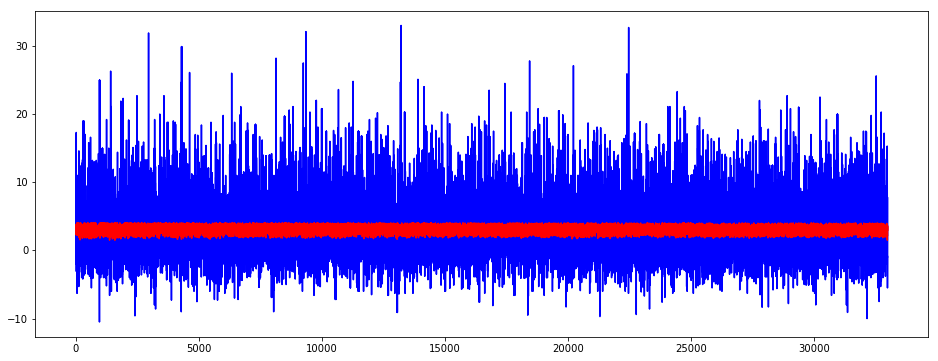

In [25]:
plt.figure(figsize=(16,6))
plt.plot(range(scores.shape[0]), scores, color='blue')
plt.plot(range(scores_pred.shape[0]), scores_pred, color='red')

O gráfico acima comprova como o nosso modelo ainda não é suficiente para predizer os jogadores. Vamos tentar melhorar isso nas próximas rodadas.

In [26]:
pkl.dump(reg, open('../../lib/python/models/nn1.pkl', 'wb'), -1)

# 4. Predictions 

Essa seção é responsável por carregar o nosso modelo treinado e predizer os jogadores para uma próxima rodada do campeonado Brasileiro.

In [27]:
df_test = pd.read_csv('../../db/cartola_scouts.csv')
reg = pkl.load(open('../../lib/python/models/nn1.pkl', 'rb'))

In [28]:
def to_samples(df):
    df_samples = df[cols_info + cols_of_interest]
    df_samples['ClubeID'] = df_samples['ClubeID'].map(dict_teams(to_int=True)) 
    df_samples['Posicao'] = df_samples['Posicao'].map(dict_positions(to_int=True))
    df_samples.reset_index(drop=True, inplace=True)
    return df_samples

In [29]:
def predict_best_players(df_samples, reg, n_players=11):
    samples = df_samples[df_samples.columns.difference(['AtletaID', 'Rodada'])].values.astype(np.float64)
    
    pred = reg.predict(samples)
    best_indexes = pred.argsort()[-n_players:]
    return df_samples.iloc[best_indexes]

def predict_best_players_by_position(df_samples, reg, n_gol=5, n_zag=5, n_lat=5, n_mei=5, n_atk=5):
    df_result = pd.DataFrame(columns=df_samples.columns)
    for n_players, pos in zip([n_gol, n_zag, n_lat, n_mei, n_atk], range(1,6)):
        samples = df_samples[df_samples['Posicao'] == pos]
        df_pos = predict_best_players(samples, reg, n_players)
        df_result = df_result.append(df_pos)

    return df_result

In [31]:
df_rodada = df_test[(df_test['Rodada'] == 13) & (df_test['Status'] == "Provável")]
df_samples = to_samples(df_rodada)

In [33]:
df_players = predict_best_players(df_samples, reg, n_players=25)
df_rodada.iloc[df_players.index][['Apelido', 'Posicao', 'ClubeID']].sort_values('Posicao')

,Apelido,Posicao,ClubeID
15861,Luan,ata,Grêmio
1839,Fred,ata,Atlético-MG
8143,Dudu,ata,Palmeiras
17059,Jean,gol,Bahia
10011,Fernando Miguel,gol,Vitória
12333,Douglas Friedrich,gol,Avaí
1355,Aranha,gol,Ponte Preta
10118,Weverton,gol,Atlético-PR
1764,Fernando Prass,gol,Palmeiras
9175,Martín Silva,gol,Vasco


In [35]:
df_players = predict_best_players_by_position(df_samples, reg, n_gol=5, n_zag=5, n_lat=5, n_mei=5, n_atk=5)
df_rodada.iloc[df_players.index][['Apelido', 'Posicao', 'ClubeID']]

,Apelido,Posicao,ClubeID
3509,Cássio,gol,Corinthians
3919,Wilson,gol,Coritiba
10118,Weverton,gol,Atlético-PR
12333,Douglas Friedrich,gol,Avaí
17059,Jean,gol,Bahia
4126,David Braz,zag,Santos
14385,Reginaldo,zag,Fluminense
16316,Balbuena,zag,Corinthians
9585,Marllon,zag,Ponte Preta
13787,Pedro Geromel,zag,Grêmio
